# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of handwritten digit recognition using a binarized neural network composed of 4 fully connected layers with 1024 neurons each, trained on the MNIST dataset of handwritten digits. 
In order to reproduce this notebook, you will need an external USB Camera connected to the PYNQ Board.

## 1. Import the package

In [1]:
import bnn

## 2. Checking available parameters

By default the following trained parameters are available for LFC network using 1 bit for weights and 1 threshold for activation:

In [2]:
print(bnn.available_params(bnn.NETWORK_LFCW1A1))

['chars_merged', 'mnist']


Two sets of weights are available for the LFCW1A1 network, the MNIST and one for character recognition (NIST).

## 3. Instantiate the classifier

Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. This example works with the LFCW1A1 for inferring MNIST handwritten digits.
Passing a runtime attribute will allow to choose between hardware accelerated or pure software inference.

In [3]:
hw_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"mnist",bnn.RUNTIME_HW)
sw_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"mnist",bnn.RUNTIME_SW)

In [4]:
print(hw_classifier.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## 4. Load the image from the camera
The image is captured from the external USB camera and stored locally. The image is then enhanced in contract and brightness to remove background noise. 
The resulting image should show the digit on a white background:

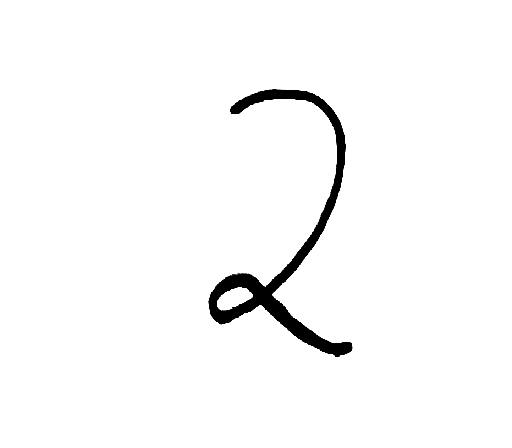

In [5]:
import cv2
from PIL import Image as PIL_Image
from PIL import ImageEnhance
from PIL import ImageOps

# says we capture an image from a webcam
cap = cv2.VideoCapture(0) 
_ , cv2_im = cap.read()
cv2_im = cv2.cvtColor(cv2_im,cv2.COLOR_BGR2RGB)
img = PIL_Image.fromarray(cv2_im).convert("L") 

#original captured image
#orig_img_path = '/home/xilinx/jupyter_notebooks/bnn/pictures/webcam_image_mnist.jpg'
#img = PIL_Image.open(orig_img_path).convert("L")     
                   
#Image enhancement                
contr = ImageEnhance.Contrast(img)
img = contr.enhance(3)                                                    # The enhancement values (contrast and brightness) 
bright = ImageEnhance.Brightness(img)                                     # depends on backgroud, external lights etc
img = bright.enhance(4.0)          

#img = img.rotate(180)                                                     # Rotate the image (depending on camera orientation)
#Adding a border for future cropping
img = ImageOps.expand(img,border=80,fill='white') 
img

## 5. Crop and scale the image
The center of mass of the image is evaluated to properly crop the image and extract the written digit only. 

In [6]:
from PIL import Image as PIL_Image
import numpy as np
import math
from scipy import misc

#Find bounding box  
inverted = ImageOps.invert(img)  
box = inverted.getbbox()  
img_new = img.crop(box)  
width, height = img_new.size  
ratio = min((28./height), (28./width))  
background = PIL_Image.new('RGB', (28,28), (255,255,255))  
if(height == width):  
    img_new = img_new.resize((28,28))  
elif(height>width):  
    img_new = img_new.resize((int(width*ratio),28))  
    background.paste(img_new, (int((28-img_new.size[0])/2),int((28-img_new.size[1])/2)))  
else:  
    img_new = img_new.resize((28, int(height*ratio)))  
    background.paste(img_new, (int((28-img_new.size[0])/2),int((28-img_new.size[1])/2)))  
  
background  
img_data=np.asarray(background)  
img_data = img_data[:,:,0]  
misc.imsave('/home/xilinx/img_webcam_mnist.png', img_data) 

## 6. Convert to BNN input format
The image is resized to comply with the MNIST standard. The image is resized at 28x28 pixels and the colors inverted. 

In [7]:
from array import *
from PIL import Image as PIL_Image
from PIL import ImageOps
img_load = PIL_Image.open('/home/xilinx/img_webcam_mnist.png').convert("L")  
# Convert to BNN input format  
# The image is resized to comply with the MNIST standard. The image is resized at 28x28 pixels and the colors inverted.   
  
#Resize the image and invert it (white on black)  
smallimg = ImageOps.invert(img_load)  
smallimg = smallimg.rotate(0)  
  
data_image = array('B')  
  
pixel = smallimg.load()  
for x in range(0,28):  
    for y in range(0,28):  
        if(pixel[y,x] == 255):  
            data_image.append(255)  
        else:  
            data_image.append(1)  
          
# Setting up the header of the MNIST format file - Required as the hardware is designed for MNIST dataset         
hexval = "{0:#0{1}x}".format(1,6)  
header = array('B')  
header.extend([0,0,8,1,0,0])  
header.append(int('0x'+hexval[2:][:2],16))  
header.append(int('0x'+hexval[2:][2:],16))  
header.extend([0,0,0,28,0,0,0,28])  
header[3] = 3 # Changing MSB for image data (0x00000803)  
data_image = header + data_image  
output_file = open('/home/xilinx/img_webcam_mnist_processed', 'wb')  
data_image.tofile(output_file)  
output_file.close()   
smallimg

## 7. Launching BNN in hardware

The image is passed in the PL and the inference is performed. Use `classify_mnist` to classify a single mnist formatted picture.

In [8]:
class_out = hw_classifier.classify_mnist("/home/xilinx/img_webcam_mnist_processed")
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.class_name(class_out)))

Inference took 8.00 microseconds
Classification rate: 125000.00 images per second
Class number: 2
Class name: 2


## 8. Launching BNN in software
The inference on the same image is performed in sofware on the ARM core

In [9]:
class_out=sw_classifier.classify_mnist("/home/xilinx/img_webcam_mnist_processed")
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.class_name(class_out)))

Inference took 18588.00 microseconds
Classification rate: 53.80 images per second
Class number: 2
Class name: 2


## 9. Reset the device

In [10]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()